### Load Libraries

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from geoplotlib.colors import create_set_cmap
import matplotlib.pyplot as plt
%matplotlib inline

### Load the filtered dataset

In [2]:
# Load it into a Dataframe using pandas
path = '../data/311_filtered.csv'
df = pd.read_csv(path)
df.head()

,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Borough,Latitude,Longitude
0,11/07/2011 04:02:50 PM,11/07/2011 05:45:14 PM,NYPD,Blocked Driveway,No Access,Street/Sidewalk,BROOKLYN,40.609242,-73.982821
1,11/07/2011 11:53:37 AM,11/07/2011 03:14:40 PM,NYPD,Illegal Parking,Double Parked Blocking Traffic,Street/Sidewalk,BROOKLYN,40.692605,-73.997137
2,11/07/2011 05:53:47 PM,11/07/2011 06:13:21 PM,NYPD,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,MANHATTAN,40.762290,-73.986106
3,11/07/2011 07:47:15 PM,11/08/2011 12:13:05 AM,NYPD,Illegal Parking,Unauthorized Bus Layover,Street/Sidewalk,MANHATTAN,40.726866,-73.979908
4,11/07/2011 09:11:39 PM,11/08/2011 04:53:53 AM,DOT,Broken Muni Meter,No Receipt,Street,MANHATTAN,40.759064,-73.978450


### Filter noise related data

In [3]:
# Keep noise related data in a seperate dataframe
df_noise = df[df['Complaint Type'].str.contains("Noise")]

In [4]:
# Unique noise types
df_noise['Complaint Type'].unique()

array(['Noise - Street/Sidewalk', 'Noise - Residential', 'Noise Survey',
       'Noise - Vehicle', 'Noise - Commercial', 'Noise - Helicopter',
       'Noise - Park', 'Noise - House of Worship', 'Collection Truck Noise'], dtype=object)

In [5]:
# Create a frequency table in order to plot
noise_freq = df_noise['Complaint Type'].groupby(df_noise['Complaint Type']).count().sort_values(ascending=1).reset_index(name='count')
noise_freq

,Complaint Type,count
0,Collection Truck Noise,1112
1,Noise - House of Worship,5008
2,Noise - Helicopter,5259
3,Noise Survey,10141
4,Noise - Park,16119
5,Noise - Vehicle,83122
6,Noise - Street/Sidewalk,179989
7,Noise - Commercial,182518
8,Noise - Residential,921438


We should better keep the noise related complain types with the highest frequency as the rest will not make any difference in the end. Thus,

In [6]:
# Save the five most significant noise incidents in a list
noise_list = list(noise_freq['Complaint Type'].values)[-5:]
noise_list

['Noise - Park',
 'Noise - Vehicle',
 'Noise - Street/Sidewalk',
 'Noise - Commercial',
 'Noise - Residential']

In [7]:
# Re-filter the data
df_noise = df_noise[df_noise['Complaint Type'].isin(noise_list)]

In [8]:
# Check unique values
df_noise['Complaint Type'].unique()

array(['Noise - Street/Sidewalk', 'Noise - Residential', 'Noise - Vehicle',
       'Noise - Commercial', 'Noise - Park'], dtype=object)

Now we are sure that the correct noise complaints are filtered. Later we will create a YEAR column to check noise complains per year in a barplot and check the trend.

In [30]:
# Create a function that gets the year of a datetime string
def getYear(s):
    first_split = s.split(' ')[0]
    return int(first_split.split('/')[-1])

In [32]:
# Now create a new column named year and store the values of the above function
df_noise['Created Year']= df_noise['Created Date'].apply(lambda x: getYear(x))

In [33]:
# List the noise complains per year
noise_freq_time = df_noise.groupby('Created Year')['Created Year'].count().reset_index(name='count').sort_values(by='Created Year', ascending=1)
noise_freq_time

,Created Year,count
0,2010,13
1,2011,23394
2,2012,179342
3,2013,217395
4,2014,283533
5,2015,323965
6,2016,284492
7,2017,71052


### Plot noise complains over year

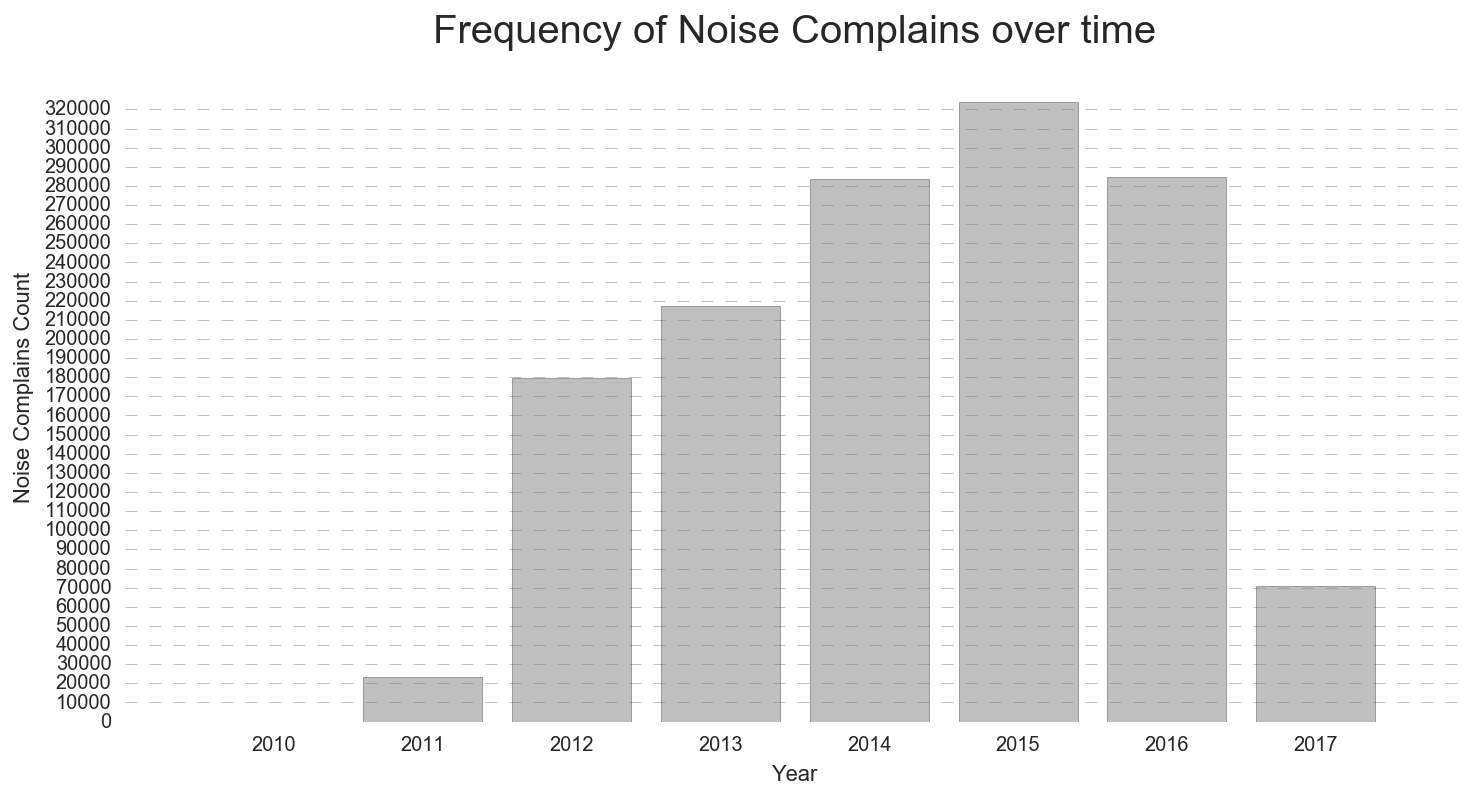

In [38]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y axes
x = noise_freq_time['Created Year']
y = noise_freq_time['count']

# Give indeces to crimes
x_pos = np.arange(len(x))

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(12, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x_pos, y, align='center', color='grey', alpha=.5)

# Match the indeces with the correct call category and assign them to the x-axis
plt.yticks(np.arange(round(min(y),-5), round(max(y),-5)+30000, 10000))
plt.xticks(x_pos, x)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Noise Complains Count")
plt.xlabel("Year")
plt.title("Frequency of Noise Complains over time",fontsize=20)

# Show the barplot
plt.show()

It is obvious that there was a constant raise in noise complains since 2010 until 2015, where this type of complains started to decline.

### Predict the borough of noise complaints using Decision Tree Classifier

In [9]:
# Encode categorical variables to digits
le = LabelEncoder()
X = le.fit_transform(df_noise['Complaint Type'])  
Y = le.fit_transform(df_noise['Borough'])

In [10]:
# Split training and testing data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [11]:
#Train the decision tree classifier
clf = tree.DecisionTreeClassifier()
#The scikit-learn fit function needs a list of lists as input even if the nested lists have length 1
clf = clf.fit(X_train[:,None], Y_train[:,None])
# Predict the testing features
pred = clf.predict(X_test[:,None])

We re-convert the numerical values of Y_test and pred to categorical, since we'll need them for the next step.


In [12]:
pred = le.inverse_transform(pred)
Y_test_inv = le.inverse_transform(Y_test)

We calculate the fraction of correct predictions.

In [13]:
print 'Fraction of correct predictions : %.2f%%' % (clf.score(X_test[:,None],Y_test[:,None])*100)

Fraction of correct predictions : 33.92%


Which means that our classifier is not that reliable to predict the correct borough if we only fit it with the noise type. But **if we restrict the training/prediction to single boroughs** (for example, predicting MANHATTAN vs. all other districts) we will see a different score for the classifier.

In [15]:
# Fit all boroughs into a list of unique boroughs and exclude nan boroughs
boroughs = sorted(list(set(df_noise['Borough'])))[:-1]

#Function to get the binary representation of a specific value
def get_binary_repr(value,borough):
    if value==borough:
        return borough
    return 'NOT'+borough

# Initiate PrettyTable
x = PrettyTable(field_names=['Borough','Correct Prediction'])
for borough in boroughs:
    df_binary_boroughs = df_noise
    df_binary_boroughs['Borough_Bin'] = df_binary_boroughs['Borough'].apply(lambda x: get_binary_repr(x,borough))

    # Split training and testing data (N.B. X is the same as before)
    Y_new = df_binary_boroughs['Borough_Bin']
    Y_new = le.fit_transform(Y_new)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_new, test_size=0.1, random_state=0)
    
    #Train classifier and predict
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train[:,None], Y_train[:,None])

    #Calculate fraction of correct predictions
    x.add_row([borough,str(clf.score(X_test[:,None],Y_test[:,None])*100)[:5]+'%'])
    
print x

+---------------+--------------------+
|    Borough    | Correct Prediction |
+---------------+--------------------+
|     BRONX     |       79.17%       |
|    BROOKLYN   |       70.03%       |
|   MANHATTAN   |       70.78%       |
|     QUEENS    |       82.55%       |
| STATEN ISLAND |       97.46%       |
+---------------+--------------------+


This is a pretty cool picture. We can easily predict and rely in our prediction that a specific noise complaint will occur in a specific borough. But let's **plot on a map** all noise complaints in different color and see why **STATEN ISLAND** borough is so predictable in terms of noise.

### Plot noise complains on map (only 2016)

In [40]:
# Create a new df only for 2016
df_noise_2016 = df_noise[df_noise['Created Year']==2016]
df_noise_2016.head()

,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Borough,Latitude,Longitude,Borough_Bin,Created Year
2839,12/21/2016 06:34:34 AM,12/21/2016 10:32:42 AM,NYPD,Noise - Commercial,Banging/Pounding,Store/Commercial,MANHATTAN,40.729656,-74.003850,NOTSTATEN ISLAND,2016
6090,12/22/2016 12:53:01 AM,12/22/2016 05:22:58 AM,NYPD,Noise - Vehicle,Engine Idling,Street/Sidewalk,MANHATTAN,40.744095,-73.982089,NOTSTATEN ISLAND,2016
6315,12/21/2016 02:22:48 AM,12/21/2016 08:13:24 AM,NYPD,Noise - Vehicle,Engine Idling,Street/Sidewalk,BROOKLYN,40.716796,-73.960489,NOTSTATEN ISLAND,2016
7506,12/21/2016 10:27:27 AM,12/21/2016 09:08:43 PM,NYPD,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,MANHATTAN,40.853686,-73.930538,NOTSTATEN ISLAND,2016
7510,12/21/2016 10:12:29 PM,12/21/2016 10:53:49 PM,NYPD,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,MANHATTAN,40.763622,-73.997015,NOTSTATEN ISLAND,2016


Firstly, we should check for outliers in the coordinates dataset.

In [41]:
#Checking if the data is clean enough (no outliers)
lats = [float(el) for el in list(df_noise_2016['Latitude'])]
longs = [float(el) for el in list(df_noise_2016['Longitude'])]
print 'Latitudes:',set([round(el) for el in lats])
print 'Longitudes:',set([round(el) for el in longs])

Latitudes: set([40.0, 41.0])
Longitudes: set([-74.0])


Longs and Lats seem normal with no outliers. Now we are ready to plot each complain as a point on a map. But before that, we should **create a dictionary**(mandatory for the **geoplotlib library**) with two keys(lat and lon) and two lists as values of each key(lists of coordinates).

In [42]:
# Create dictionary and put each complaint's coordinates as a seperate key,value pair
geo_dict = {}
for complaint in noise_list:
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_noise_2016[df_noise_2016['Complaint Type']==complaint]['Latitude'])],
                             "lon": [float(el) for el in list(df_noise_2016[df_noise_2016['Complaint Type']==complaint]['Longitude'])]}
    geo_dict[complaint] = geo_data_for_plotting

And now we are fully ready for plotting the complains with different color per noise complain type on a map.

In [44]:
#Ready for plotting
colors = ['black', 'white', 'red', 'green', 'blue']

for i,complain in enumerate(noise_list):
    # Create a legend
    print '%s\t\t ----->\t\t%d observations\t\t ----->\t\t%s' % (colors[i],len(geo_dict[complain]['lon']),complain)
    # Fit the map with dots
    geoplotlib.dot(geo_dict[complain], color=colors[i], point_size=.8)

# Create an BoundigBox for the limits of the map
bbox = BoundingBox(north=max(geo_data_for_plotting['lat']),
                   west=min(geo_data_for_plotting['lon']),
                   south=min(geo_data_for_plotting['lat']),
                   east=max(geo_data_for_plotting['lon']))
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

black		 ----->		2403 observations		 ----->		Noise - Park
white		 ----->		17848 observations		 ----->		Noise - Vehicle
red		 ----->		42956 observations		 ----->		Noise - Street/Sidewalk
green		 ----->		41712 observations		 ----->		Noise - Commercial
blue		 ----->		179573 observations		 ----->		Noise - Residential


So maybe the reason why the **STATEN ISLAND** is so well predictable is that as seen on the map, it is not that dense meaning that there are not a lot of complains related to noise in this borough.